## Dealing with missing data

In [187]:
n <- 100
param <- c(1, -3)
x <- runif(n)
y <- param[1] + param[2] * x + rnorm(n)

In [188]:
missing <- sample(c(TRUE, FALSE), n, replace=TRUE, prob = c(0.3, 0.7))

In [189]:
df <- data.frame(x, y)
df$x[missing] <- NA

#### Which technique is the following?

In [190]:
ols <- lm(df$y ~ df$x)

In [191]:
summary(ols)


Call:
lm(formula = df$y ~ df$x)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.96881 -0.59721  0.00413  0.52855  2.99585 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.0881     0.2784   3.908 0.000242 ***
df$x         -3.0662     0.4814  -6.369 3.13e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.069 on 59 degrees of freedom
  (39 observations deleted due to missingness)
Multiple R-squared:  0.4074,	Adjusted R-squared:  0.3974 
F-statistic: 40.56 on 1 and 59 DF,  p-value: 3.134e-08


#### Please demonstrate what trade-off was made by the above handling of the missing values

#### How close are the slope estimates between the "drop missing data" vs "mean imputed" method?

#### Scenario: X1 impacts the probability of missing data in X2 AND impacts Y

In [1]:
n <- 100
x1 <- runif(n)
x2 <- rnorm(n, 0, sd=0.3)
param <- c(1, 2, 3)
y <- cbind(1, x1, x2) %*% param + rnorm(n)

In [2]:
missing <- sapply(x1, function(xi) sample(c(TRUE, FALSE), 1, prob = c(xi, 1-xi)))

In [3]:
df <- data.frame(x1, x2, y)
df$x2[missing] <- NA

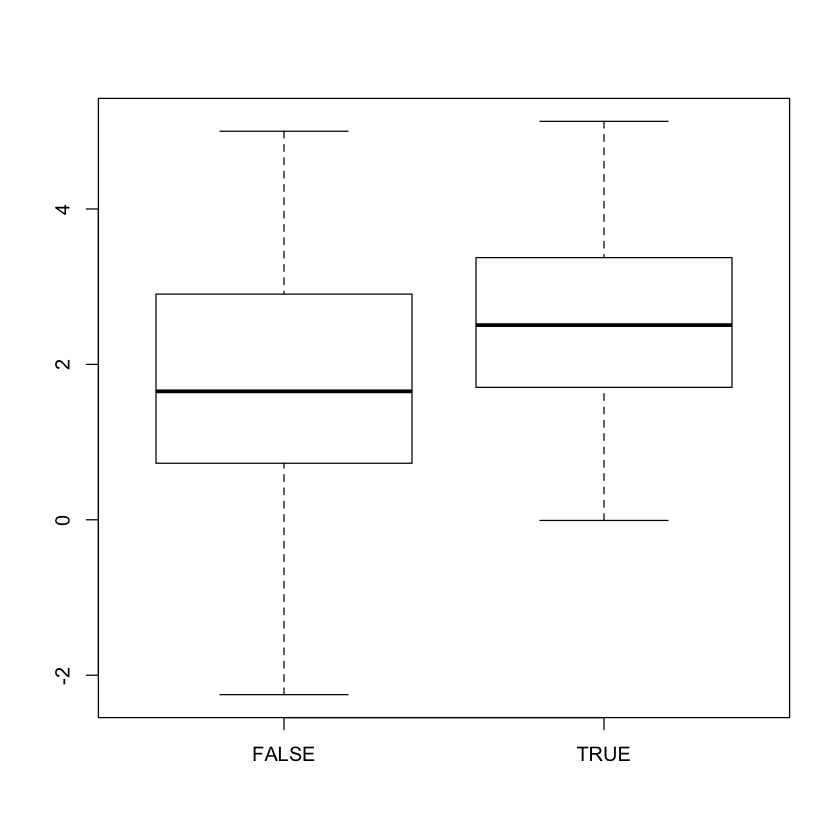

In [4]:
boxplot(df$y ~ is.na(df$x2))

In [5]:
summary(lm(y ~ x1 + x2, df))


Call:
lm(formula = y ~ x1 + x2, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2239 -0.9502 -0.1099  0.8478  1.7100 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.1714     0.2491   4.702 2.13e-05 ***
x1            1.7252     0.6282   2.746  0.00841 ** 
x2            3.2739     0.4017   8.150 1.13e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.045 on 49 degrees of freedom
  (48 observations deleted due to missingness)
Multiple R-squared:  0.6083,	Adjusted R-squared:  0.5923 
F-statistic: 38.04 on 2 and 49 DF,  p-value: 1.068e-10


In [6]:
num_sim <- 1000
out <- matrix(NA, ncol=2, nrow=num_sim)
for(i in seq_len(num_sim)){
    sim_missing <- sapply(x1, function(xi) sample(c(TRUE, FALSE), 1, replace=TRUE, prob = c(xi, 1-xi)))
    sim_y <- cbind(1, x1, x2) %*% param + rnorm(n)
    # What is this model?
    ols <- lm(sim_y ~ x1 + x2, subset=!sim_missing)
    out[i, 1] <- ols$coefficients[3]
    # What is this model?
    ols <- lm(sim_y ~ x2, subset=!sim_missing)
    out[i, 2] <- ols$coefficients[2]
}

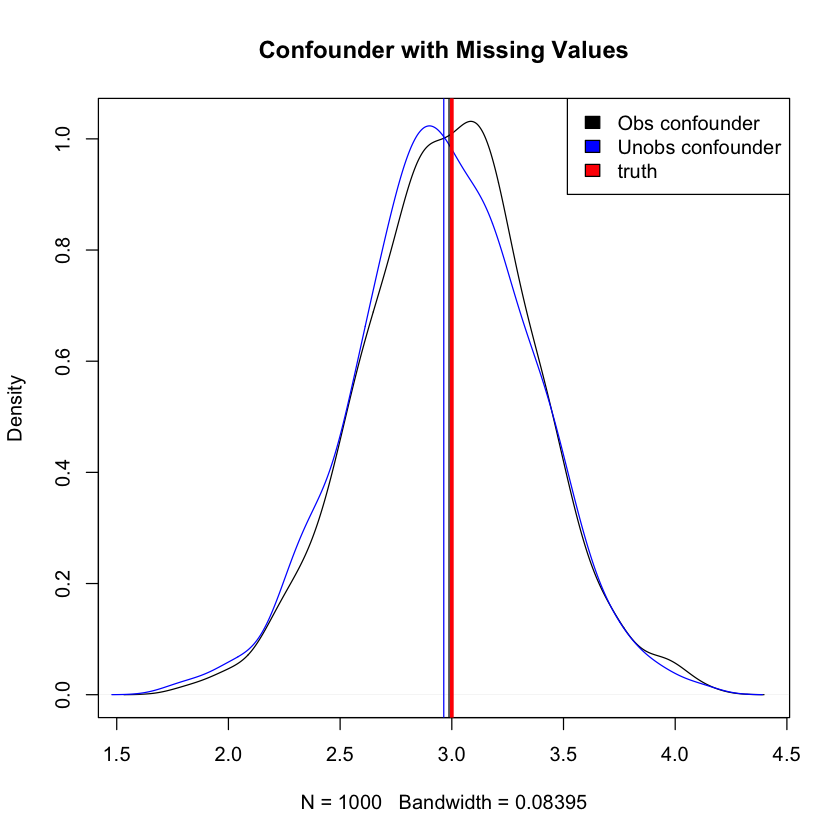

In [7]:
plot(density(out[, 1]), col="black", main="Confounder with Missing Values")
lines(density(out[, 2]), col="blue")
abline(v=param[3], col="red", lwd=3)
abline(v=mean(out[, 1]), col="black")
abline(v=mean(out[, 2]), col="blue")
legend("topright", legend=c("Obs confounder", "Unobs confounder", "truth"), fill=c("black", "blue", "red"))

#### Repeat the simulation above but make X2 a function of X1 by changing the mean of X2

What changes?

#### Example of Imputing via Regression vs using the Mean

In [308]:
n <- 100
x1 <- runif(n)
x2 <- rnorm(n, mean = x1^2, sd=0.3)
param <- c(1, 2, 3)

In [314]:
k <- 3
num_sim <- 1000
out <- matrix(NA, ncol=3, nrow=num_sim)
for(i in seq_len(num_sim)){
    sim_y <- cbind(1, x1, x2) %*% param + rnorm(n)
    sim_missing <- sapply(x1, function(xi) sample(c(TRUE, FALSE), 1, replace=TRUE, prob = c(xi, 1-xi)))
    ols <- lm(sim_y ~ x1 + x2, subset=!sim_missing)
    out[i, 1] <- ols$coefficients[k]
    x2_new <- x2
    x2_new[sim_missing] <- predict(lm(x2 ~ x1, subset=!sim_missing),
                                   data.frame(x1=x1[sim_missing]))
    ols <- lm(sim_y ~ x1 + x2_new)
    out[i, 2] <- ols$coefficients[k]
    x2_new[sim_missing] <- mean(x2[!sim_missing])
    ols <- lm(sim_y ~ x1 + x2_new)
    out[i, 3] <- ols$coefficients[k]
}

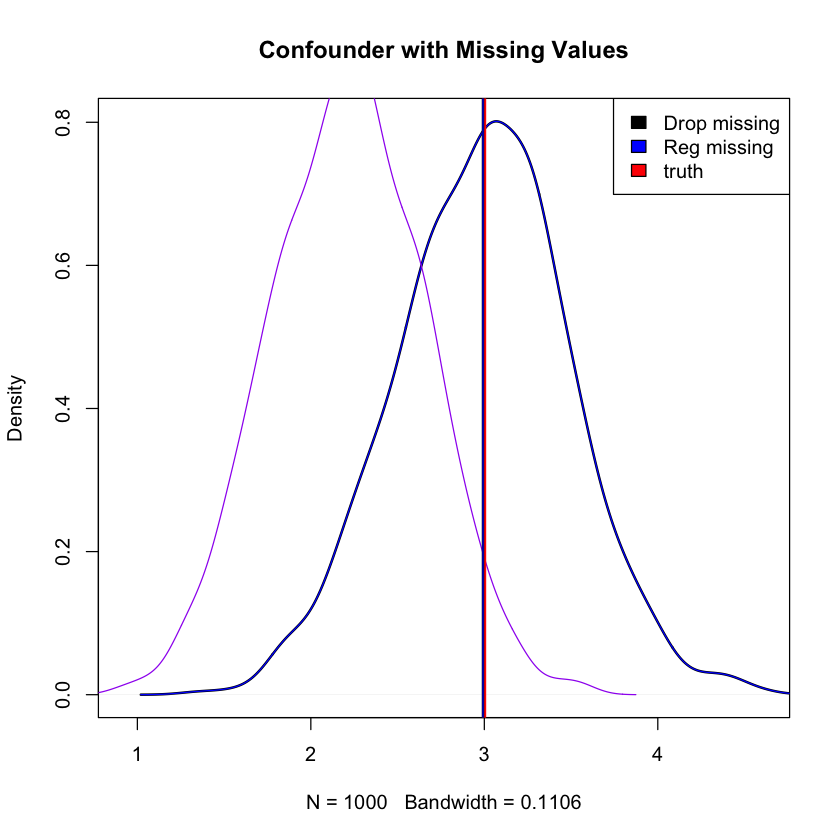

In [315]:
plot(density(out[, 1]), col="black", main="Confounder with Missing Values", lwd=2, xlim=range(out))
lines(density(out[, 2]), col="blue")
lines(density(out[, 3]), col="purple")
abline(v=param[3], col="red", lwd=3)
abline(v=mean(out[, 1]), col="black", lwd=2)
abline(v=mean(out[, 2]), col="blue")
legend("topright", legend=c("Drop missing", "Reg missing", "truth"), fill=c("black", "blue", "red"))

#### See the graph below, why is it biased?

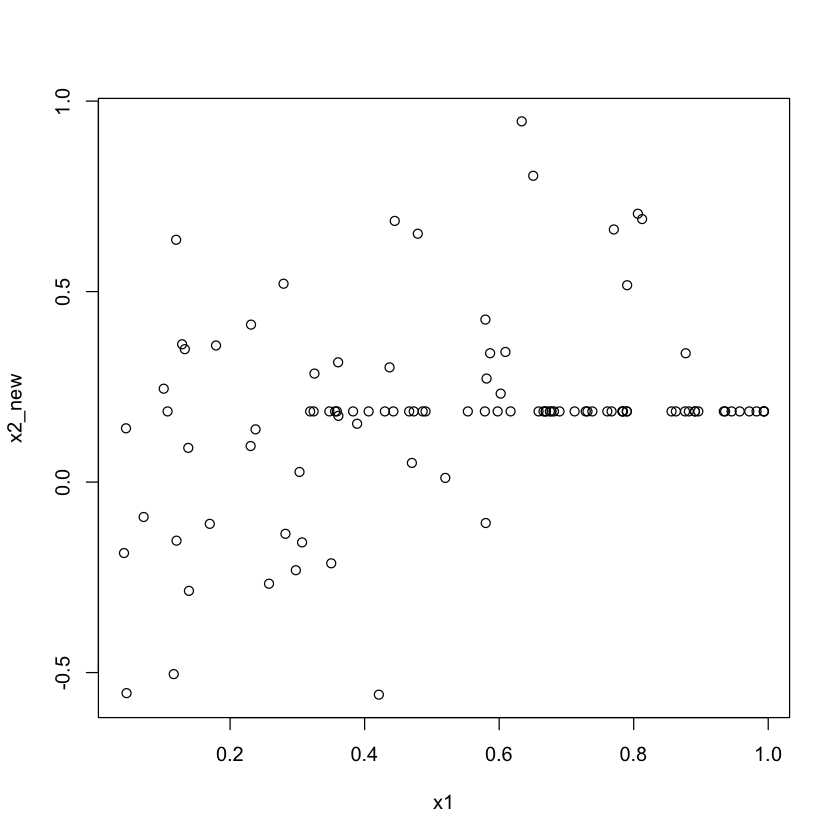

In [316]:
plot(x1, x2_new)